In [1]:
import argparse
import os
import torch

from attrdict import AttrDict

from sgan.data.loader import data_loader
from sgan.models import CCTrajectoryGenerator as TrajectoryGenerator
from sgan.losses import displacement_error, final_displacement_error
from sgan.utils import relative_to_abs, get_dset_path
from scipy.stats import gaussian_kde
import numpy as np

import matplotlib.pyplot as plt
import cv2
from PIL import Image

model_path = "checkpoints/univ/attn_in_with_lstm_abs/checkpoint_with_model.pt"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def get_generator(checkpoint):
    args = AttrDict(checkpoint['args'])
    generator = TrajectoryGenerator(
        obs_len=args.obs_len,
        pred_len=args.pred_len,
        embedding_dim=args.embedding_dim,
        encoder_h_dim=args.encoder_h_dim_g,
        decoder_h_dim=args.decoder_h_dim_g,
        mlp_dim=args.mlp_dim,
        num_layers=args.num_layers,
        noise_dim=args.noise_dim,
        noise_type=args.noise_type,
        noise_mix_type=args.noise_mix_type,
        pooling_type=args.pooling_type,
        pool_every_timestep=args.pool_every_timestep,
        dropout=args.dropout,
        bottleneck_dim=args.bottleneck_dim,
        neighborhood_size=args.neighborhood_size,
        grid_size=args.grid_size,
        batch_norm=args.batch_norm)
    generator.load_state_dict(checkpoint['g_state'])
    generator.cuda()
    generator.train()
    return generator

In [4]:
checkpoint = torch.load(model_path)
generator = get_generator(checkpoint)
_args = AttrDict(checkpoint['args'])
print(_args)
_args.batch_size=1
_args.loader_num_workers=0
path = get_dset_path(_args.dataset_name, "test")
print(path)
dset, loader = data_loader(_args, path)

AttrDict({'dataset_name': 'univ', 'delim': 'tab', 'loader_num_workers': 4, 'obs_len': 8, 'pred_len': 12, 'skip': 1, 'batch_size': 64, 'num_iterations': 6487, 'num_epochs': 200, 'embedding_dim': 16, 'num_layers': 1, 'dropout': 0.0, 'batch_norm': 0, 'mlp_dim': 64, 'encoder_h_dim_g': 32, 'decoder_h_dim_g': 32, 'noise_dim': (8,), 'noise_type': 'gaussian', 'noise_mix_type': 'local', 'clipping_threshold_g': 2.0, 'g_learning_rate': 0.0001, 'g_steps': 1, 'pooling_type': 'none', 'pool_every_timestep': False, 'bottleneck_dim': 8, 'neighborhood_size': 2.0, 'grid_size': 8, 'd_type': 'global', 'encoder_h_dim_d': 48, 'd_learning_rate': 0.001, 'd_steps': 1, 'clipping_threshold_d': 0.0, 'l2_loss_weight': 1.0, 'best_k': 20, 'output_dir': '/media/renhao/Research/GitHub/trajectory_prediction/sgan_raw/checkpoints/univ/attn_in_with_lstm_abs', 'print_every': 100, 'checkpoint_every': 300, 'checkpoint_name': 'checkpoint', 'checkpoint_start_from': 'None', 'restore_from_checkpoint': 0, 'num_samples_check': 5000

In [5]:
generator.cuda()
generator.eval()

CCTrajectoryGenerator(
  (encoder): Encoder(
    (encoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (decoder): LSTM(16, 32)
    (spatial_embedding): Linear(in_features=2, out_features=16, bias=True)
    (hidden2pos): Linear(in_features=32, out_features=2, bias=True)
  )
  (mlp_decoder_context): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=24, bias=True)
    (3): ReLU()
  )
  (rcca): RCCA(
    (cca): CrissCrossAttention(
      (query_conv): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (value_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=3)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (encoder): Encoder(
      (encoder): LSTM(16, 32)
      (spatial_embedding): Linear(in_features=2, out_features=16, b

In [6]:
def cord_to_pxi(traj, H = None):
    """
    traj: (2, steps)
    """
    if H is None:
        return traj
    _, h = cv2.invert(H)
    pixel_points = cv2.perspectiveTransform(
        np.array(
            [traj.T]
    ), h)
    return pixel_points

In [44]:
index = 1
sample_batch = None
for batch in iter(loader):
    index -= 1
    if index == 0:
        sample_batch = batch

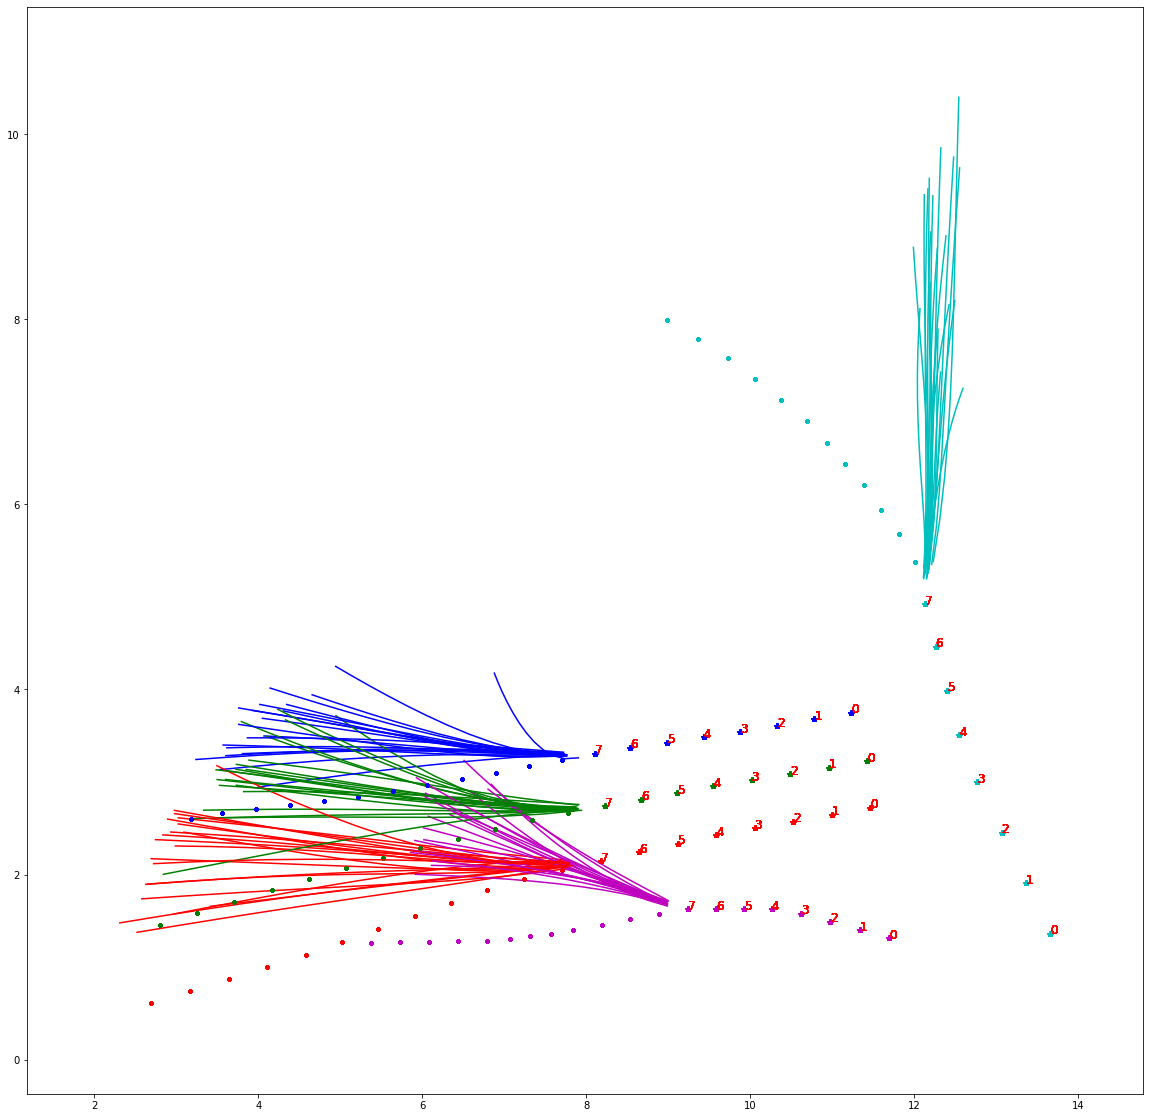

In [46]:
import random
plt.rcParams["figure.figsize"] = (20,20)
# H = np.array([[0.02104651, 0., 0.],
#                            [0., -0.02386598, 13.74680446],
#                            [0., 0., 1.]])
H = None

color_list = list('bgrcmy')
with torch.no_grad():
    batch = [tensor.cuda() for tensor in sample_batch]
    visible_obs = [i for i in range(5)]#random.sample(range(len(batch)), 4) 
    if len(visible_obs) != 0:
        for i in range(4):
            batch[i] = batch[i][:, visible_obs]

        batch[-1][0][1] = len(visible_obs)
    count =1 
    for i in range(20):
        (obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel,
             non_linear_ped, loss_mask, seq_start_end) = batch
        # plt.subplot(10,2,count)
        count +=1
        pred_traj_fake_rel = generator(
                    obs_traj, obs_traj_rel, seq_start_end
                )
    #         pred_traj_fake_rel = pred_traj_fake_rel[-args.pred_len :]
        pred_traj_fake = relative_to_abs(pred_traj_fake_rel, obs_traj[-1])

        # build inversed relative trajectories
        inv_pred_traj_gt_rel = torch.zeros_like(pred_traj_fake.flip(dims=[0]))
        inv_pred_traj_gt_rel[1:] = pred_traj_fake.flip(dims=[0])[1:] - pred_traj_fake.flip(dims=[0])[:-1]
        inv_pred_traj_fake_rel = generator(
            inv_pred_traj_gt_rel, 
            pred_traj_fake.flip(dims=[0]), 
            seq_start_end
        )
        inv_pred_traj_fake = relative_to_abs(inv_pred_traj_fake_rel, pred_traj_fake.flip(dims=[0])[-1])



        obs_traj, pred_traj_fake, pred_traj_gt = (
            obs_traj.permute(1,2,0).cpu().numpy(),
            pred_traj_fake.permute(1,2,0).cpu().numpy(),
            pred_traj_gt.permute(1,2,0).cpu().numpy(),
    #             inv_pred_traj_fake.permute(1,2,0).cpu().numpy()
        )
        for idx,(obs_rw,fake_rw,real_rw,inv_fake_rw) in enumerate(zip(obs_traj,pred_traj_fake, pred_traj_gt,inv_pred_traj_fake)):
            # plt.subplot(pred_traj_fake.shape[0]//3+1,3, count )
            if H is not None:
                obs = cord_to_pxi(obs_rw, H).T
                fake = cord_to_pxi(fake_rw, H).T
                real = cord_to_pxi(real_rw, H).T
                img = cv2.imread("/media/renhao/Research/GitHub/TrajectoryDatasets/eth-ucy/scenes/univ.png")[:,:,::-1]
                plt.imshow(img)
            else:
                obs, fake, real = obs_rw, fake_rw, real_rw
                # img = cv2.imread("/media/renhao/Research/GitHub/TrajectoryDatasets/eth-ucy/scenes/univ.png")[:,:,::-1]
    #             img = cv2.rotate(img,cv2.ROTATE_180_COUNTERCLOCKWISE)
            
            color = color_list[idx % len(color_list)]
            plt.plot(obs[0], obs[1], color+"*")
            plt.plot(real[0], real[1],color+ ".")
            plt.plot(fake[0], fake[1], color + '-')

            # plt.plot(inv_fake[0], inv_fake[1], 'c.')
            for idx,(x, y) in enumerate(zip(obs[0], obs[1])):
                plt.text(x, y, str(idx), color="red", fontsize=12)
            # for idx,(x, y) in enumerate(zip(real[0], real[1])):
            #     plt.text(x, y, str(idx+8), color="red", fontsize=12)
            # for idx,(x, y) in enumerate(zip(fake[0], fake[1])):
            #     plt.text(x, y, str(idx+8), color="red", fontsize=12)

            plt.margins(0.1)

In [47]:
(obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel,
             non_linear_ped, loss_mask, seq_start_end) = batch

In [48]:
with torch.no_grad():
    # outputs = generator.encoder(obs_traj_rel)
    # output = outputs.permute(2, 0, 1 )
    outputs = generator.encoder(
        obs_traj_rel, seq_start_end
    )
    scenes,atts_H,atts_W = generator.rcca.predict(outputs, obs_traj,  seq_start_end)

In [60]:
atts_W[0].sum() + atts_H[0].sum()

tensor(40., device='cuda:0')

In [34]:
scenes.size()

torch.Size([8, 4, 32])

In [14]:
attn_h

tensor([[[0.0000, 0.0173, 0.0175,  ..., 0.0176, 0.0176, 0.0175],
         [0.0168, 0.0000, 0.0175,  ..., 0.0175, 0.0175, 0.0174],
         [0.0168, 0.0174, 0.0000,  ..., 0.0176, 0.0175, 0.0174],
         ...,
         [0.0172, 0.0180, 0.0183,  ..., 0.0000, 0.0180, 0.0178],
         [0.0173, 0.0182, 0.0185,  ..., 0.0183, 0.0000, 0.0180],
         [0.0174, 0.0183, 0.0186,  ..., 0.0184, 0.0182, 0.0000]],

        [[0.0000, 0.0173, 0.0175,  ..., 0.0176, 0.0176, 0.0176],
         [0.0168, 0.0000, 0.0175,  ..., 0.0175, 0.0175, 0.0174],
         [0.0168, 0.0174, 0.0000,  ..., 0.0176, 0.0175, 0.0175],
         ...,
         [0.0172, 0.0180, 0.0184,  ..., 0.0000, 0.0180, 0.0179],
         [0.0173, 0.0182, 0.0185,  ..., 0.0183, 0.0000, 0.0181],
         [0.0174, 0.0183, 0.0187,  ..., 0.0184, 0.0183, 0.0000]],

        [[0.0000, 0.0173, 0.0175,  ..., 0.0177, 0.0176, 0.0176],
         [0.0168, 0.0000, 0.0175,  ..., 0.0176, 0.0176, 0.0176],
         [0.0168, 0.0174, 0.0000,  ..., 0.0177, 0.0177, 0.

In [13]:
generator.attn.register_forward_hook()

TypeError: register_forward_hook() missing 1 required positional argument: 'hook'

In [13]:
obs_traj

tensor([[[10.7868,  3.6763],
         [10.9587,  3.1546],
         [10.9993,  2.6467],
         [13.3645,  1.9059],
         [11.3411,  1.4012],
         [11.2237,  0.5224],
         [12.5806,  6.6963],
         [ 5.8930,  7.3433],
         [ 4.7331,  5.8338],
         [ 5.1387,  5.4114],
         [ 5.3102,  4.9715],
         [ 4.9297,  4.3758],
         [ 5.8448,  5.3732],
         [ 0.7857,  2.0604],
         [ 0.8459,  0.6628],
         [ 4.4724, 10.5180],
         [ 5.0956, 10.8552],
         [ 4.7108, 11.1096],
         [ 4.8258, 10.6817],
         [ 3.9729, 11.6032],
         [ 4.1935, 11.3900],
         [ 6.8624,  7.7140],
         [ 6.5021,  8.3292],
         [ 8.0187, 11.7013],
         [ 7.9023, 11.9728],
         [ 7.4715, 13.2695],
         [ 6.7521, 11.5566],
         [ 9.0698,  4.3415],
         [ 8.4218,  4.1649],
         [ 6.9603,  5.6281],
         [13.4035,  6.1541],
         [13.8627,  5.9202],
         [ 7.8203,  8.3020],
         [ 8.4908,  8.5748],
         [ 4.9

In [12]:
with torch.no_grad():
    print(generator.rcca.spatial_embedding(generator.rcca.normalize_obs_traj(obs_traj,seq_start_end)))

tensor([[[-3.9659,  4.1445,  9.8501,  ...,  0.2800,  2.0862,  1.4511],
         [-4.6299,  4.2080, 10.6678,  ...,  0.6370,  2.1397,  1.9839],
         [-5.3664,  4.0714, 11.2563,  ...,  1.0774,  2.0891,  2.6798],
         ...,
         [ 3.4658,  5.6275,  4.0737,  ..., -4.1866,  2.6518, -5.6236],
         [ 5.4164, 10.9837, 10.2019,  ..., -6.4234,  5.4358, -9.9970],
         [ 5.1428,  1.4282, -4.2076,  ..., -4.2227,  0.3736, -4.9229]],

        [[-4.4050,  3.4024,  9.1842,  ...,  0.6842,  1.7055,  2.2007],
         [-5.0760,  3.4397,  9.9693,  ...,  1.0507,  1.7453,  2.7527],
         [-5.8258,  3.2970, 10.5626,  ...,  1.4999,  1.6919,  3.4630],
         ...,
         [ 3.5264,  5.5380,  3.8704,  ..., -4.2012,  2.6025, -5.6298],
         [ 5.4661, 10.8238,  9.9020,  ..., -6.4169,  5.3495, -9.9582],
         [ 5.2678,  1.5522, -4.1524,  ..., -4.3191,  0.4357, -5.0921]],

        [[-4.8368,  2.6650,  8.5175,  ...,  1.0833,  1.3271,  2.9418],
         [-5.5207,  2.6746,  9.2740,  ...,  1

In [15]:
generator.rcca.normalize_obs_traj(obs_traj,seq_start_end).min()

tensor(-7.1664, device='cuda:0')

In [23]:
obs_traj_rel.min()

tensor(-0.5087, device='cuda:0')

In [11]:
generator.encoder(obs_traj_rel,obs_traj,seq_start_end)

tensor([[[ 0.0325, -0.2773, -0.3869,  ..., -0.0507,  0.0774,  0.0833],
         [ 0.3502, -0.1987,  0.1762,  ...,  0.0690, -0.0117, -0.6568],
         [-0.0808, -0.0585,  0.2972,  ..., -0.0592,  0.3984,  0.0335],
         ...,
         [ 0.0451,  0.0400,  0.3097,  ...,  0.0143,  0.1488, -0.1774],
         [ 0.0174, -0.0015,  0.7824,  ..., -0.5264, -0.0155, -0.0229],
         [-0.0799,  0.0493,  0.2876,  ...,  0.5436,  0.1556, -0.0526]],

        [[ 0.1384, -0.3771, -0.0180,  ..., -0.0500,  0.1186, -0.2373],
         [ 0.2028, -0.3362,  0.0934,  ...,  0.0154,  0.0623, -0.7199],
         [ 0.0676, -0.5052,  0.1164,  ..., -0.0482,  0.4602, -0.2085],
         ...,
         [ 0.0383, -0.0158,  0.2463,  ...,  0.2258,  0.1362, -0.4863],
         [ 0.0208, -0.0041,  0.4801,  ..., -0.1368, -0.0028, -0.1933],
         [-0.0086,  0.0912,  0.1727,  ..., -0.0787,  0.0753,  0.0269]],

        [[ 0.2293, -0.4600,  0.0338,  ..., -0.0476,  0.1954, -0.5416],
         [ 0.2438, -0.4656,  0.0989,  ..., -0